# BBM418 - Computer Vision Lab Assignment 1
# Student Name: Emirhan Utku
# Student ID: 2210765029
# Date: March 30, 2025

In [89]:
import cv2
import numpy as np
import os
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt

# -----------------------------------------------
# 0. Helper Function for RANSAC
# -----------------------------------------------

In [90]:
def average_distance_in_image(line1, line2, width, height, n_samples=10):
  
    (A1, B1, C1) = line1
    (A2, B2, C2) = line2
    
    distances = []
    
    step_x = max(1, width // n_samples)
    for x in range(0, width, step_x):
        # If B1 is not too small, we can solve y = -(A1*x + C1)/B1
        if abs(B1) > 1e-6:
            y = -(A1*x + C1)/B1
            if 0 <= y < height:
                # distance from (x,y) to line2 is |A2*x + B2*y + C2|
                dist_pt_line2 = abs(A2*x + B2*y + C2)
                distances.append(dist_pt_line2)
    
    step_y = max(1, height // n_samples)
    for y in range(0, height, step_y):
        # If A1 is not too small, we can solve x = -(B1*y + C1)/A1
        if abs(A1) > 1e-6:
            x = -(B1*y + C1)/A1
            if 0 <= x < width:
                dist_pt_line2 = abs(A2*x + B2*y + C2)
                distances.append(dist_pt_line2)
    
    if len(distances) == 0:
        # If we couldn't sample anything, return a large number so it won't be considered "similar"
        return 1e6
    
    return sum(distances) / len(distances)


In [91]:
def double_check_refined_lines(refined_lines, image_shape, geom_thresh=10, n_samples=10):

    h, w = image_shape[:2]
    final_lines = []
    for line in refined_lines:
        A, B, C, inlier_count = line
        merged = False
        for idx, existing_line in enumerate(final_lines):
            Ae, Be, Ce, inlier_e = existing_line
            avg_dist = average_distance_in_image((A, B, C), (Ae, Be, Ce), width=w, height=h, n_samples=n_samples)
            if avg_dist < geom_thresh:
                # If lines are geometrically similar, keep the one with the higher inlier count.
                if inlier_count > inlier_e:
                    final_lines[idx] = line
                merged = True
                break
        if not merged:
            final_lines.append(line)
    return final_lines


# -----------------------------------------------
# 1. Preprocessing and Edge Detection
# -----------------------------------------------

In [94]:
def load_and_resize(image_path, scale_factor=0.3):
    image = cv2.imread(image_path)
    
    if image is None:
         raise ValueError("Image not loaded: " + image_path)
            
    resized = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
    return resized

def edge_detection(image):
    blur = 5
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (31, 31), blur)
    
    median = np.median(blurred_image)
    lower, upper = int(max(0, 0.66 * median))+20, int(min(255, 1.33 * median))+20
    edges = cv2.Canny(blurred_image, lower, upper)

    
    while(True):
        if np.sum(edges > 0) < 4_000:
            blur -= 0.05
            blurred_image = cv2.GaussianBlur(gray_image, (31, 31), blur)
            edges = cv2.Canny(blurred_image, lower, upper)
        
        else:
            return edges
    


# -----------------------------------------------
# 2. Hough Transform Implementation
# -----------------------------------------------

In [95]:
def hough_transform(edges, rho_resolution=1, theta_resolution=np.pi/180):
    height, width = edges.shape
    diag_len = int(np.sqrt(height**2 + width**2))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)
    thetas = np.arange(0, np.pi, theta_resolution)
    
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(edges)  
    

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            theta = thetas[t_idx]
            rho = int(round(x * np.cos(theta) + y * np.sin(theta))) + diag_len
            accumulator[rho, t_idx] += 1
            
    return accumulator, rhos, thetas

In [96]:
def detect_lines_from_hough(accumulator, rhos, thetas, fraction=0.1, min_lines=50, max_lines=75):

    peaks = []
    for i in range(accumulator.shape[0]):
        for j in range(accumulator.shape[1]):
            if accumulator[i, j] > 0:
                peaks.append((accumulator[i, j], rhos[i], thetas[j]))
    
    # Sort the candidate lines in descending order by their vote counts.
    peaks.sort(key=lambda x: x[0], reverse=True)
    
    # Extract the (rho, theta) for each candidate line.
    candidate_lines = [(rho, theta) for (votes, rho, theta) in peaks]
    n = len(candidate_lines)
    
    if n == 0:
        return []
    

    k = int(fraction * n)

    if k < min_lines:
        k = min(min_lines, n)

        elif k > max_lines:
        k = max_lines
        
    return candidate_lines[:k]


# -----------------------------------------------
# 3. RANSAC for Robust Line Fitting
# -----------------------------------------------

In [97]:
def normalize_line(A, B, C):

    norm = np.sqrt(A**2 + B**2)
    if norm < 1e-9:
        return (A, B, C)
    A /= norm
    B /= norm
    C /= norm

    if (A < 0) or (abs(A) < 1e-9 and B < 0):
        A = -A
        B = -B
        C = -C
    return (A, B, C)

def line_angle_dist(A, B, C):

    angle = np.arctan2(B, A)
    dist = -C
    return angle, dist

def is_similar_line(line1, line2, angle_thresh_deg=5, dist_thresh=10):

    (A1, B1, C1) = line1
    (A2, B2, C2) = line2
    angle1, d1 = line_angle_dist(A1, B1, C1)
    angle2, d2 = line_angle_dist(A2, B2, C2)
    

    angle_diff = abs(angle1 - angle2)
    angle_diff = min(angle_diff, 2*np.pi - angle_diff)
    angle_diff_deg = np.degrees(angle_diff)
    
    dist_diff = abs(d1 - d2)


    return (angle_diff_deg < angle_thresh_deg) and (dist_diff < dist_thresh)

In [98]:
def get_points_near_line(edges, rho, theta, distance_thresh=1.0):

    y_idxs, x_idxs = np.nonzero(edges)
    points = np.column_stack((x_idxs, y_idxs))  # shape: (N, 2)
    
    
    distances = np.abs(points[:, 0]*np.cos(theta) + points[:, 1]*np.sin(theta) - rho)
    inlier_mask = distances < distance_thresh
    return points[inlier_mask]

def ransac_line_fitting(points, num_iterations=1000, distance_threshold=2.0):

    best_inlier_count = 0
    best_line = None
    n_points = points.shape[0]
    
    if n_points < 2:
        return None
    
    for _ in range(num_iterations):
        idx = np.random.choice(n_points, 2, replace=False)
        p1, p2 = points[idx]
        

        A = p2[1] - p1[1]
        B = p1[0] - p2[0]
        C = p2[0]*p1[1] - p1[0]*p2[1]
        

        (A, B, C) = normalize_line(A, B, C)
        
        # Distances to line
        distances = np.abs(A*points[:, 0] + B*points[:, 1] + C)
        inlier_mask = distances < distance_threshold
        inlier_count = np.sum(inlier_mask)
        
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_line = (A, B, C, inlier_count)
    
    return best_line

def draw_line(img, line, color=(0, 255, 0), thickness=2):

    A, B, C = line
    h, w = img.shape[:2]
    if np.abs(B) > 1e-6:

        pt1 = (0, int(-C/B))
        pt2 = (w, int((-C - A*w)/B))
    else:
        x = int(-C/A)
        pt1 = (x, 0)
        pt2 = (x, h)
    cv2.line(img, pt1, pt2, color, thickness)

In [99]:
def pick_rectangle_lines(refined_lines):

    
    horizontal_lines = []
    vertical_lines = []
    for (A, B, C, inlier) in refined_lines:
        
        angle_rad = np.arctan(-(A/B))             
        angle_deg = np.degrees(angle_rad) 
        angle = angle_deg % 180

        if angle < 25 or angle > 151:
            if abs(B) < 1e-6:
                continue
            y_int = -C / B  
            horizontal_lines.append(((A, B, C, inlier), y_int))

        elif 75 < angle <105:
            if abs(A) < 1e-6:
                continue
            x_int = -C / A  
            vertical_lines.append(((A, B, C, inlier), x_int))
    

    if len(horizontal_lines) >= 2:
    
        horizontal_lines.sort(key=lambda x: x[1])
        top_line = horizontal_lines[0][0]
        bottom_line = horizontal_lines[-1][0]
       
    else:
        top_line = None
        bottom_line = None

    if len(vertical_lines) >= 2:

        vertical_lines.sort(key=lambda x: x[1])
        left_line = vertical_lines[0][0]
        right_line = vertical_lines[-1][0]
        
     
    else:
        left_line = None
        right_line = None

    rectangle_lines = []
    if top_line is not None:
        rectangle_lines.append(top_line)
    if bottom_line is not None:
        rectangle_lines.append(bottom_line)
    if left_line is not None:
        rectangle_lines.append(left_line)
    if right_line is not None:
        rectangle_lines.append(right_line)
        
        
    if len(rectangle_lines)< 4:
        print("No lines were found to form a quadritale.")
        return refined_lines
    
    return rectangle_lines


# ---------------------------
# 4. Quadrilateral Detection from Refined Lines
# ---------------------------

In [100]:
def compute_intersection(line1, line2):

    A1, B1, C1 = line1
    A2, B2, C2 = line2
    det = A1*B2 - A2*B1
    if abs(det) < 1e-6:
        return None  
    x = (B2 * (-C1) - B1 * (-C2)) / det
    y = (A1 * (-C2) - A2 * (-C1)) / det
    return (x, y)

def find_document_quadrilateral(refined_lines, image_shape):

    intersections = []
    h, w = image_shape[:2]
    
    for i in range(len(refined_lines)):
        for j in range(i+1, len(refined_lines)):
            line1 = refined_lines[i][:3]  # (A, B, C)
            line2 = refined_lines[j][:3]
            
            angle1 = np.arctan2(line1[1], line1[0])
            angle2 = np.arctan2(line2[1], line2[0])
            angle_diff = abs(angle1 - angle2)
            angle_diff = min(angle_diff, np.pi - angle_diff)
            if angle_diff < np.deg2rad(10): 
                continue
            
            pt = compute_intersection(line1, line2)
            if pt is None:
                continue
            x, y = pt
            if 0 <= x <= w and 0 <= y <= h:
                intersections.append(pt)
                
    intersections = np.array(intersections, dtype=np.float32)
    if intersections.shape[0] == 0:
        return None  
    
    # Compute the convex hull of the intersections.
    hull = cv2.convexHull(intersections)
    
    # Approximate the convex hull polygon.
    epsilon = 0.05 * cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    
    if len(approx) == 4:

        quad = [tuple(pt[0]) for pt in approx]
        return quad
    else:
        # As a fallback, return the hull points.
        return [tuple(pt[0]) for pt in hull]



# ---------------------------
# 4. Custom Perspective Transform (Homography + Vectorized Bilinear Interpolation)
# ---------------------------

In [101]:
def order_points(pts):

    rect = np.zeros((4, 2), dtype="float64")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


In [102]:
def compute_homography(src_pts, dst_pts):

    assert len(src_pts) == 4 and len(dst_pts) == 4, "Need exactly 4 source and 4 destination points."
    
    # Build the 8x9 matrix A (2 rows per correspondence)
    A = []
    for i in range(4):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([-x, -y, -1,   0,   0,   0,   x*u, y*u, u])
        A.append([ 0,   0,   0,  -x, -y,  -1,   x*v, y*v, v])
    A = np.array(A, dtype=np.float64)  # shape (8,9)
    
    # Solve A * h = 0 using SVD. The solution is the last column of V (or last row of V^T).
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]  # eigenvector with smallest eigenvalue
    
    # Reshape to 3x3
    H = h.reshape(3, 3)
    
    # Normalize so that H[2,2] = 1 if it's not 0
    if abs(H[2,2]) > 1e-8:
        H /= H[2,2]
    
    return H


In [103]:
def warp_image_bilinear(src_image, H, out_width, out_height):

    
    H_inv = np.linalg.inv(H)
    
    if len(src_image.shape) == 3:
        h_src, w_src, c_src = src_image.shape
        warped = np.zeros((out_height, out_width, c_src), dtype=src_image.dtype)
    else:
        h_src, w_src = src_image.shape
        c_src = 1
        warped = np.zeros((out_height, out_width), dtype=src_image.dtype)
    
    
    X, Y = np.meshgrid(np.arange(out_width), np.arange(out_height))
    
    
    X_flat = X.flatten()  
    Y_flat = Y.flatten()  
    ones = np.ones_like(X_flat) 
    

    dst_pts = np.stack([X_flat, Y_flat, ones], axis=0)  
    
    src_pts = H_inv @ dst_pts  
    
    
    x_prime = src_pts[0] / src_pts[2]  
    y_prime = src_pts[1] / src_pts[2]
    
    # 3) Bilinear interpolation
    x0 = np.floor(x_prime).astype(int)
    y0 = np.floor(y_prime).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1
    
    alpha = x_prime - x0
    beta = y_prime - y0
    
    # Valid range check
    valid_mask = (x0 >= 0) & (x1 < w_src) & (y0 >= 0) & (y1 < h_src)
    
    # For convenience, define a function to safely gather pixel values
    def gather_values(img, xx, yy):
        xx = np.clip(xx, 0, img.shape[1] - 1)
        yy = np.clip(yy, 0, img.shape[0] - 1)
        return img[yy, xx]

    if c_src > 1:
        # Color image, shape: H_src x W_src x C
        I_y0x0 = gather_values(src_image, x0, y0)
        I_y0x1 = gather_values(src_image, x1, y0)
        I_y1x0 = gather_values(src_image, x0, y1)
        I_y1x1 = gather_values(src_image, x1, y1)
        
        # Expand alpha, beta to (N,1) so broadcasting works for color channels
        alpha_2d = alpha[:, np.newaxis]
        beta_2d = beta[:, np.newaxis]
        
        out_val = (1 - alpha_2d)*(1 - beta_2d)*I_y0x0 \
                  + alpha_2d*(1 - beta_2d)*I_y0x1 \
                  + (1 - alpha_2d)*beta_2d*I_y1x0 \
                  + alpha_2d*beta_2d*I_y1x1
        
        # Zero out invalid
        out_val[~valid_mask] = 0
        
        # Reshape back to (out_height, out_width, C)
        warped = out_val.reshape((out_height, out_width, c_src))
    else:
        # Grayscale image, shape: H_src x W_src
        I_y0x0 = gather_values(src_image, x0, y0)
        I_y0x1 = gather_values(src_image, x1, y0)
        I_y1x0 = gather_values(src_image, x0, y1)
        I_y1x1 = gather_values(src_image, x1, y1)
        
        out_val = (1 - alpha)*(1 - beta)*I_y0x0 \
                  + alpha*(1 - beta)*I_y0x1 \
                  + (1 - alpha)*beta*I_y1x0 \
                  + alpha*beta*I_y1x1
        
        out_val[~valid_mask] = 0
        warped = out_val.reshape((out_height, out_width))
    
    return warped


In [104]:
def four_point_transform_manual_bilinear(src_image, src_pts):

    # 1) Order corners
    rect = order_points(src_pts)  # [top-left, top-right, bottom-right, bottom-left]
    (tl, tr, br, bl) = rect

    # 2) Compute the new image width and height
    widthA = np.sqrt((br[0] - bl[0])**2 + (br[1] - bl[1])**2)
    widthB = np.sqrt((tr[0] - tl[0])**2 + (tr[1] - tl[1])**2)
    maxWidth = int(max(widthA, widthB))

    heightA = np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2)
    heightB = np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2)
    maxHeight = int(max(heightA, heightB))

    # 3) Destination corners for a "tight" rectangle
    dst_pts = np.array([
        [0,           0],
        [maxWidth-1,  0],
        [maxWidth-1,  maxHeight-1],
        [0,           maxHeight-1]
    ], dtype=np.float64)

    # 4) Compute homography from rect -> dst_pts
    H = compute_homography(rect, dst_pts)

    # 5) Warp using bilinear interpolation
    warped = warp_image_bilinear(src_image, H, maxWidth, maxHeight)
    return warped


# -----------------------------------------------
# 5. SSIM Evaluation
# -----------------------------------------------

In [105]:
def compute_ssim(image1, image2):
    # Convert to 8-bit if needed
    if image1.dtype != np.uint8:
        image1 = cv2.convertScaleAbs(image1)
    if image2.dtype != np.uint8:
        image2 = cv2.convertScaleAbs(image2)
    
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(gray1, gray2, full=True)
    return score


# -----------------------------------------------
# 6. Dataset Processing
# -----------------------------------------------

In [107]:
def process_and_save_sample(image_path, gt_path,ransac_dist_threshold, scale_factor=0.3):
    
    # Load full-resolution images
    orig_image = cv2.imread(image_path)
    if orig_image is None:
        raise ValueError("Original image not loaded: " + image_path)
    orig_gt_image = cv2.imread(gt_path)
    if orig_gt_image is None:
        raise ValueError("Ground truth image not loaded: " + gt_path)
   
    # Create a rescaled copy for processing
   
    image = load_and_resize(image_path, scale_factor)
    gt_image = load_and_resize(gt_path, scale_factor)
    
    # Edge Detection on rescaled image
    edges = edge_detection(image)
    cv2.imwrite("sample_edges.jpg", edges)
    print("Edges saved")
    
    # Hough Transform to detect candidate lines on rescaled image
    accumulator, rhos, thetas = hough_transform(edges)
    candidate_lines = detect_lines_from_hough(accumulator, rhos, thetas)
    print("Number of candidate lines from Hough:", len(candidate_lines))
   
    
    refined_lines = []  # Each element: (A, B, C, inlier_count)
    for (rho, theta) in candidate_lines:
        line_points = get_points_near_line(edges, rho, theta, distance_thresh=2.0)
        if len(line_points) < 2:
            continue
        best_line = ransac_line_fitting(line_points, num_iterations=2500, distance_threshold=1.5)

        if best_line is None:
            continue
        (A, B, C, inlier_count) = best_line

        new_line_normalized = normalize_line(A, B, C)
        skip = False
        for line_existing in refined_lines:
            (Ae, Be, Ce, inlier_e) = line_existing
            existing_normalized = (Ae, Be, Ce)
            if is_similar_line(new_line_normalized, existing_normalized, angle_thresh_deg=45, dist_thresh=ransac_dist_threshold):
                skip = True
                if inlier_count > inlier_e:
                    refined_lines.remove(line_existing)
                    refined_lines.append((A, B, C, inlier_count))
                break
        if not skip:
            refined_lines.append((A, B, C, inlier_count))
    
    refined_lines = double_check_refined_lines(refined_lines, image_shape=edges.shape,
                                           geom_thresh=85, n_samples=10)
    
    if(len(refined_lines)>4):
        print("There are ",len(refined_lines)," lines. Checking again because there are more than 4 lines...")
        refined_lines = pick_rectangle_lines(refined_lines)
        
    print(f"Refined lines count (after filtering): {len(refined_lines)}")
  
    
    # Draw refined lines on rescaled image
    image_with_lines = image.copy()
    for (A, B, C, inlier_count) in refined_lines:
        draw_line(image_with_lines, (A, B, C), color=(0, 0, 255), thickness=2)
    cv2.imwrite("sample_refined_lines.jpg", image_with_lines)
    print("Refined lines image saved as sample_refined_lines.jpg")
    
    # Also draw candidate Hough lines (blue) for comparison
    image_hough = image.copy()
    for rho, theta in candidate_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        c = -rho
        draw_line(image_hough, (a, b, c), color=(255, 0, 0), thickness=2)
    cv2.imwrite("sample_hough_lines.jpg", image_hough)
    

    quad = find_document_quadrilateral(refined_lines, image.shape)
    if quad is not None and len(quad) == 4:
        print("Quadrilateral corners found:", quad)
        for pt in quad:
            cv2.circle(image_with_lines, (int(pt[0]), int(pt[1])), 5, (0, 255, 0), -1)
    else:
        print("Quadrilateral not detected. Returned points:", quad)
    cv2.imwrite("sample_corners.jpg", image_with_lines)
    print("Refined lines image with corners saved as sample_corners.jpg")
    

    if quad is not None and len(quad) == 4:
        scale = 1.0 / scale_factor
        quad_original = [(pt[0]*scale, pt[1]*scale) for pt in quad]
        
        
        quad_np = np.array(quad_original, dtype=np.float64)
        warped = four_point_transform_manual_bilinear(orig_image, quad_np)
        if warped is not None and warped.size!=0:
            
            cv2.imwrite("warped_result.jpg", warped)
            print("Saved warped (rectified) document as warped_result.jpg")
        
        else:
            warped= None
    else:
        warped = None
        print("Could not perform perspective transform due to missing quadrilateral.")
    
    # Compute SSIM between warped full-resolution image and full-resolution ground truth
    if warped is not None:
        if warped.shape != orig_gt_image.shape:
            warped_for_ssim = cv2.resize(warped, (orig_gt_image.shape[1], orig_gt_image.shape[0]))
        else:
            warped_for_ssim = warped
        ssim_value = compute_ssim(orig_gt_image, warped_for_ssim)
        print("SSIM between warped image and ground truth:", ssim_value)
    else:
        disorted_image = cv2.imread(image_path)
        
        if disorted_image.shape != orig_gt_image.shape:
            disorted_image = cv2.resize(disorted_image, (orig_gt_image.shape[1], orig_gt_image.shape[0]))

        ssim_value = compute_ssim(orig_gt_image, disorted_image)
    
    return {
        "edges": edges,
        "hough_lines_image": image_hough,
        "ransac_lines_image": image_with_lines,
        "corrected": warped,
        "ssim": ssim_value
    }

# -----------------------------------------------
# 7. Calculate Results
# -----------------------------------------------

In [108]:
def calculate_results_and_ssim_for_folder(distorted_folder, gt_folder,ransac_dist_threshold,folder_name, scale_factor=0.25, num_images=50):

    distorted_files = [os.path.join(distorted_folder, f)
                       for f in os.listdir(distorted_folder)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Shuffle and select a subset of images
    random.shuffle(distorted_files)
    selected_files = distorted_files[:num_images]
    
    full_results = {}
    ssim_results = {}
    
    for i, file_path in enumerate(selected_files, start=1):
        # Construct the corresponding ground-truth image path (assuming same filename)
        gt_path = os.path.join(gt_folder, os.path.basename(file_path))
        print(f"------------------------- IMAGE {i} START ------------------------------------")
        print(f"Processing image: {file_path}")
        
        # Call process_and_save_sample and get the full result dictionary
        result = process_and_save_sample(file_path, gt_path, ransac_dist_threshold, scale_factor=scale_factor)
        full_results[file_path] = result
        
        # Store the SSIM value from the result
        ssim_results[file_path] = result["ssim"]
        print(f"Image: {file_path}, SSIM: {result['ssim']}")
        print(f"------------------------- IMAGE {i} END ------------------------------------")
    
    # Compute the average SSIM value
    average_ssim = sum(ssim_results.values()) / len(ssim_results) if ssim_results else 0
    
    return full_results, average_ssim

# -----------------------------------------------
# 8. Function that can be used to control images one by one
# -----------------------------------------------

In [145]:
sample_distorted_image = 'WarpDoc/distorted/rotate/0043.jpg'
sample_ground_truth_image = 'WarpDoc/digital/rotate/0043.jpg'


# Process the sample image and save outputs as JPG files
outputs = process_and_save_sample(sample_distorted_image, sample_ground_truth_image,125, scale_factor=0.3)


Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(447.99377, 387.72406), (326.27274, 579.0), (185.42192, 411.50174), (350.77917, 267.9841)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.37777800721199345


# -----------------------------------------------
# 9. Results for Each Folder
# -----------------------------------------------

# COMPUTE AVERAGE SSIM FOR CURVED FOLDER

### Ransac threshold : 125

In [21]:
full_results_curved, average_ssim_curved = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/curved/', 
         'WarpDoc/digital/curved/',
         125,
         "Curved folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 125," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0055.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(755.5127, 8.558375), (641.9628, 1113.0889), (133.36732, 920.5341), (237.11084, 177.03897)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7236406184115755
Image: WarpDoc/distorted/curved/0055.jpg, SSIM: 0.7236406184115755
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0031.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Ch

Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(794.107, 1014.13104), (196.53441, 1076.4371), (184.91183, 196.9951), (741.0479, 227.89156)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5661466875896125
Image: WarpDoc/distorted/curved/0030.jpg, SSIM: 0.5661466875896125
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0023.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as samp

/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.601393688727946
Image: WarpDoc/distorted/curved/0026.jpg, SSIM: 0.601393688727946
------------------------- IMAGE 14 END ------------------------------------
------------------------- IMAGE 15 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0084.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(376.71747, 483.0353), (84.987114, 519.5016), (123.111786, 91.96068), (363.89053, 53.33307)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5046911640020585
Image: WarpDoc/distorted/curved/0084.jpg, SSIM: 0.5046911640020585
------------------------- IMAGE 15 END ------------------------------------
------------------

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5320149313871158
Image: WarpDoc/distorted/curved/0051.jpg, SSIM: 0.5320149313871158
------------------------- IMAGE 25 END ------------------------------------
------------------------- IMAGE 26 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0063.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(764.51483, 269.52475), (738.38275, 1105.7513), (255.58174, 1053.5002), (203.44357, 278.87595)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.4877197364948503
Image: WarpDoc/distorted/curved/0063.jpg, SSIM: 0.4877197364948503
------------------------- IMAGE 26 END ------------------------------------
-------------

There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(724.40485, 229.78323), (722.1819, 1065.603), (73.52455, 1006.8664), (192.42026, 240.86624)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5653980625492593
Image: WarpDoc/distorted/curved/0022.jpg, SSIM: 0.5653980625492593
------------------------- IMAGE 36 END ------------------------------------
------------------------- IMAGE 37 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0029.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(7

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5792837029239554
Image: WarpDoc/distorted/curved/0018.jpg, SSIM: 0.5792837029239554
------------------------- IMAGE 47 END ------------------------------------
------------------------- IMAGE 48 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0005.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(868.3372, 195.20879), (785.46796, 984.64746), (119.81074, 1079.7413), (136.97841, 209.09535)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5439066046006915
Image: WarpDoc/distorted/curved/0005.jpg, SSIM: 0.5439066046006915
------------------------- IMAGE 48 END ------------------------------------
--------------

In [22]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Curved folder with a RANSAC distance threshold of 125 : {average_ssim_curved:.4f}")

------------------------------------------------------------------------------

Average SSIM of the Curved folder with a RANSAC distance threshold of 125 : 0.5345


### Ransac threshold : 150

In [23]:
full_results_curved, average_ssim_curved = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/curved/', 
         'WarpDoc/digital/curved/',
         150,
         "Curved folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 150," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0043.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(775.9553, 264.39133), (662.5189, 1072.2797), (172.92096, 932.88025), (288.57382, 272.00665)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.592206336638999
Image: WarpDoc/distorted/curved/0043.jpg, SSIM: 0.592206336638999
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0045.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (af

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(721.80725, 70.47835), (649.8072, 1058.4791), (154.20102, 1004.78845), (236.41786, 68.78118)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7169252754711681
Image: WarpDoc/distorted/curved/0028.jpg, SSIM: 0.7169252754711681
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0061.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(677.66766, 326.61502), (664.90063, 1003.2676), (191.59517, 973.1207), (217.5202, 324.99478)]
Refi

Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(141.44525, 78.40299), (688.9562, 223.4934), (722.4413, 1097.1499)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/curved/0041.jpg, SSIM: 0.32320453325339904
------------------------- IMAGE 24 END ------------------------------------
------------------------- IMAGE 25 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0063.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(764.549, 269.43143), (738.4055, 1106.0237), (256.0813, 1053.5259), (203.28203, 

Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(776.07355, 990.0371), (191.38605, 1061.9987), (108.51398, 151.94055), (692.70593, 175.30824)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6129301519898792
Image: WarpDoc/distorted/curved/0033.jpg, SSIM: 0.6129301519898792
------------------------- IMAGE 35 END ------------------------------------
------------------------- IMAGE 36 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0003.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after fil

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(868.9167, 195.24686), (784.92664, 984.1533), (119.816414, 1079.1691), (137.00381, 209.05653)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5443265385732586
Image: WarpDoc/distorted/curved/0005.jpg, SSIM: 0.5443265385732586
------------------------- IMAGE 46 END ------------------------------------
------------------------- IMAGE 47 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0053.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(875.5185, 1044.2593), (157.69214, 1106.679), (111.24246, 185.76352), (814.92847, 195.99896)]
Ref

In [24]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Curved folder with a RANSAC distance threshold of 150 : {average_ssim_curved:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Curved folder with a RANSAC distance threshold of 150 : 0.5260


### Ransac threshold : 200

In [25]:
full_results_curved, average_ssim_curved = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/curved/', 
         'WarpDoc/digital/curved/',
         200,
         "Curved folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 200," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0051.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(441.5248, 987.62634), (302.99417, 1016.7907), (169.49391, 41.497158), (395.25443, 146.85207)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5316574009386932
Image: WarpDoc/distorted/curved/0051.jpg, SSIM: 0.5316574009386932
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0010.jpg
Edges saved
Number of candidate

SSIM between warped image and ground truth: 0.6539020125945932
Image: WarpDoc/distorted/curved/0044.jpg, SSIM: 0.6539020125945932
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0091.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 2
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(313.06592, 423.19507)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/curved/0091.jpg, SSIM: 0.27606357255700903
------------------------- IMAGE 13 END ------------------------------------
------------------------- IMAGE 14 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0038.jpg
Edges saved
Number of candidate lines fro

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 2
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(334.75568, 466.41675)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/curved/0096.jpg, SSIM: 0.2440625123552824
------------------------- IMAGE 24 END ------------------------------------
------------------------- IMAGE 25 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0019.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(794.14514, 1062.0247), (123.41526, 1060.544), (215.62193, 151.28378), (729.6145, 161.99197)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_r

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(389.91293, 528.9847), (353.24484, 288.60507)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/curved/0081.jpg, SSIM: 0.36860622801471243
------------------------- IMAGE 35 END ------------------------------------
------------------------- IMAGE 36 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0088.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(358.6241, 500.9081), (71.27646, 495.9962), (79.14259, 104.65588), (346.89624, 108.02385)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified)

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5711527083768495
Image: WarpDoc/distorted/curved/0057.jpg, SSIM: 0.5711527083768495
------------------------- IMAGE 46 END ------------------------------------
------------------------- IMAGE 47 START ------------------------------------
Processing image: WarpDoc/distorted/curved/0065.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(806.10034, 218.01234), (695.3631, 1011.3541), (180.26108, 855.6641), (254.06801, 150.0699)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6293108700369021
Image: WarpDoc/distorted/curved/0065.jpg, SSIM: 0.6293108700369021
------------------------- IMAGE 47 END ------------------------------------
----------------

In [26]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Curved folder with a RANSAC distance threshold of 200 : {average_ssim_curved:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Curved folder with a RANSAC distance threshold of 200 : 0.4922


----

# COMPUTE AVERAGE SSIM FOR FOLD FOLDER

### Ransac threshold : 125

In [27]:
full_results_fold, average_ssim_fold = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/fold/', 
         'WarpDoc/digital/fold/',
         125,
         "Fold folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 125," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0091.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 2
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: None
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/fold/0091.jpg, SSIM: 0.1558742542739365
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0054.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(740.23944, 978.75165), (154.55055, 1071.2289), (127.32597, 140.14822), (724.55444, 77.983185)]
Ref

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6036355968883257
Image: WarpDoc/distorted/fold/0071.jpg, SSIM: 0.6036355968883257
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0075.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(445.83246, 1.8080279), (349.99765, 599.5148), (109.63899, 603.04944), (89.86131, 3.1264396)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.18104695938461954
Image: WarpDoc/distorted/fold/0075.jpg, SSIM: 0.18104695938461954
------------------------- IMAGE 13 END ------------------------------------
-------------------

Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(790.41864, 1106.8568), (29.309639, 973.4666), (261.56378, 169.50996), (737.7198, 96.79648)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6279479877647552
Image: WarpDoc/distorted/fold/0028.jpg, SSIM: 0.6279479877647552
------------------------- IMAGE 24 END ------------------------------------
------------------------- IMAGE 25 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0031.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.3300431788407694
Image: WarpDoc/distorted/fold/0085.jpg, SSIM: 0.3300431788407694
------------------------- IMAGE 34 END ------------------------------------
------------------------- IMAGE 35 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0023.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(780.19763, 363.37463), (672.65314, 1030.1508), (108.00517, 899.84735), (272.9336, 284.11462)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6498454537885265
Image: WarpDoc/distorted/fold/0023.jpg, SSIM: 0.6498454537885265
------------------------- IMAGE 35 END ------------------------------------
--------------------

SSIM between warped image and ground truth: 0.6153153820009546
Image: WarpDoc/distorted/fold/0017.jpg, SSIM: 0.6153153820009546
------------------------- IMAGE 45 END ------------------------------------
------------------------- IMAGE 46 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0019.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(236.75581, 935.4222), (144.43979, 697.4943), (596.16406, 73.61466), (802.9353, 848.3176)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.640656423789618
Image: WarpDoc/distorted/fold/0019.jpg, SSIM: 0.640656423789618
------------------------- IMAGE 46 END -

In [28]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Fold folder with a RANSAC distance threshold of 125 : {average_ssim_fold:.4f}")

------------------------------------------------------------------------------

Average SSIM of the Fold folder with a RANSAC distance threshold of 125 : 0.4895


### Ransac threshold : 150

In [29]:
full_results_fold, average_ssim_fold = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/fold/', 
         'WarpDoc/digital/fold/',
         150,
         "Fold folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 150," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0078.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(380.31967, 89.1968), (373.9592, 542.9106), (39.293255, 533.06744), (83.383385, 92.16617)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.562981107615497
Image: WarpDoc/distorted/fold/0078.jpg, SSIM: 0.562981107615497
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0043.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilatera

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(818.55475, 285.8537), (671.35333, 1052.9364), (129.04562, 894.7633), (358.4616, 223.07114)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7261191162134949
Image: WarpDoc/distorted/fold/0068.jpg, SSIM: 0.7261191162134949
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0089.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(368.10083, 498.50314), (83.0, 489.59375), (83.0, 262.27942), (346.6393, 258.40237)]
Refined lines imag

Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(694.4515, 990.8942), (175.43541, 954.3193), (239.56367, 264.94055), (683.4419, 286.28085)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.534138650055517
Image: WarpDoc/distorted/fold/0036.jpg, SSIM: 0.534138650055517
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0007.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refi

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.4050837813177433
Image: WarpDoc/distorted/fold/0057.jpg, SSIM: 0.4050837813177433
------------------------- IMAGE 33 END ------------------------------------
------------------------- IMAGE 34 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0003.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(744.7678, 243.53839), (680.5988, 1006.4364), (165.58394, 971.56555), (216.23631, 217.11182)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5541129306013809
Image: WarpDoc/distorted/fold/0003.jpg, SSIM: 0.5541129306013809
----------------------

/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.3853303166756846
Image: WarpDoc/distorted/fold/0037.jpg, SSIM: 0.3853303166756846
------------------------- IMAGE 40 END ------------------------------------
------------------------- IMAGE 41 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0099.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 2
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(366.78098, 288.36453)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/fold/0099.jpg, SSIM: 0.27122496137931473
------------------------- IMAGE 41 END ------------------------------------
------------------------- IMAGE 42 START ------------------------------------
Processing image: WarpDoc/distorted/fold/003

In [30]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Fold folder with a RANSAC distance threshold of 150 : {average_ssim_fold:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Fold folder with a RANSAC distance threshold of 150 : 0.5164


### Ransac threshold : 200

In [31]:
full_results_fold, average_ssim_fold = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/fold/', 
         'WarpDoc/digital/fold/',
         200,
         "Fold folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 200," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0068.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(818.60626, 285.94617), (671.4404, 1053.0873), (129.08102, 894.07086), (358.64246, 223.04512)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7260414142942563
Image: WarpDoc/distorted/fold/0068.jpg, SSIM: 0.7260414142942563
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0048.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  8  lines. Checking again because there are more than 4 lines...
Refined lines count (after

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(777.6613, 963.2891), (174.43442, 1014.5945), (146.08743, 209.06796), (567.3819, 235.39886)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.48653625657340654
Image: WarpDoc/distorted/fold/0020.jpg, SSIM: 0.48653625657340654
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0034.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(739.56824, 1091.4716), (1

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7497108686518206
Image: WarpDoc/distorted/fold/0005.jpg, SSIM: 0.7497108686518206
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0037.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(877.0, 1026.6031), (126.45459, 1014.68976), (36.21942, 274.0094), (877.0, 230.21875)]
Refined lines image with corners saved as sample_corners.jpg


/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.38534734699051065
Image: WarpDoc/distorted/fold/0037.jpg, SSIM: 0.38534734699051065
------------------------- IMAGE 24 END ------------------------------------
------------------------- IMAGE 25 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0057.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(765.68536, 873.0214), (177.65181, 854.6454), (190.55943, 178.28555), (729.5143, 185.77103)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.41931304209365416
Image: WarpDoc/distorted/fold/0057.jpg, SSIM: 0.41931304209365416
-------------------

Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(88.89931, 127.51767), (815.496, 240.54382), (851.3168, 960.7974)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/fold/0065.jpg, SSIM: 0.4758055294045043
------------------------- IMAGE 36 END ------------------------------------
------------------------- IMAGE 37 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0046.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(797.5526, 

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(445.8607, 1.8706642), (350.23816, 599.51154), (109.55349, 603.15826), (90.19737, 3.1186056)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.18104688732374205
Image: WarpDoc/distorted/fold/0075.jpg, SSIM: 0.18104688732374205
------------------------- IMAGE 47 END ------------------------------------
------------------------- IMAGE 48 START ------------------------------------
Processing image: WarpDoc/distorted/fold/0045.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(796.3172, 976.4723), (204.16486, 1111.3188), (91.306046, 208.44838), (782.2161, 125.70466)]
Refined

In [32]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Fold folder with a RANSAC distance threshold of 200 : {average_ssim_fold:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Fold folder with a RANSAC distance threshold of 200 : 0.4963


-----

# COMPUTE AVERAGE SSIM FOR INCOMPLETE FOLDER

### Ransac threshold : 125

In [33]:
full_results_incomplete, average_ssim_incomplete = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/incomplete/', 
         'WarpDoc/digital/incomplete/',
         125,
         "Incomplete folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 125," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0002.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(368.72983, 155.76822), (352.3443, 475.28616), (109.87538, 483.79385), (73.53092, 70.61469)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6166912748107943
Image: WarpDoc/distorted/incomplete/0002.jpg, SSIM: 0.6166912748107943
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0029.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(383.89282, 474.16714), (91.318184, 479.8482), (96.56964, 108.74511), (378.2109, 111.94558)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.34308205731007657
Image: WarpDoc/distorted/incomplete/0086.jpg, SSIM: 0.34308205731007657
------------------------- IMAGE 13 END ------------------------------------
------------------------- IMAGE 14 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0008.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(390.0747, 542.8768), (66.02873, 516.1906), (66.59895, 381.0483), (378.47824, 370.29385)]

Image: WarpDoc/distorted/incomplete/0021.jpg, SSIM: 0.5095502243768628
------------------------- IMAGE 24 END ------------------------------------
------------------------- IMAGE 25 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0063.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(55.978577, 534.04456), (78.30153, 227.104), (380.0, 31.0), (380.0, 591.5323)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5460724779970793
Image: WarpDoc/distorted/incomplete/0063.jpg, SSIM: 0.5460724779970793
------------------------- IMAGE 25 END ------------------------------------
------------------------- IMAGE 26 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0065.jpg
Ed

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(381.0008, 505.06485), (107.657814, 43.631554), (376.38898, 122.28458)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0080.jpg, SSIM: 0.35660012923107653
------------------------- IMAGE 36 END ------------------------------------
------------------------- IMAGE 37 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0044.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(89.33927, 508.62186), (48.763626, 55.527157), (370.64212, 520.02606)]
Refined lines image with corners saved as sample_corners

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 2
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(428.0665, 468.22318)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0011.jpg, SSIM: 0.2122849567772635
------------------------- IMAGE 48 END ------------------------------------
------------------------- IMAGE 49 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0010.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(400.09265, 509.53375), (68.227295, 504.1811), (83.267, 52.990128), (375.05362, 27.532234)]
Refined lines image with c

In [34]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Incomplete folder with a RANSAC distance threshold of 125 : {average_ssim_incomplete:.4f}")

------------------------------------------------------------------------------

Average SSIM of the Incomplete folder with a RANSAC distance threshold of 125 : 0.4293


### Ransac threshold : 150

In [35]:
full_results_incomplete, average_ssim_incomplete = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/incomplete/', 
         'WarpDoc/digital/incomplete/',
         150,
         "Incomplete folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 150," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0095.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(377.31952, 542.5312), (105.25553, 475.79852), (98.56949, 114.75229), (375.43094, 113.8201)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.29369819496675487
Image: WarpDoc/distorted/incomplete/0095.jpg, SSIM: 0.29369819496675487
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0083.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined 

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.4033169172155755
Image: WarpDoc/distorted/incomplete/0025.jpg, SSIM: 0.4033169172155755
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0052.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(343.0, 50.825893), (90.0, 51.955357)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0052.jpg, SSIM: 0.30740480145688986
------------------------- IMAGE 13 END ------------------------------------
------------------------- IMAGE 14 START ------------------------------------
Processing 

SSIM between warped image and ground truth: 0.5432181046593179
Image: WarpDoc/distorted/incomplete/0008.jpg, SSIM: 0.5432181046593179
------------------------- IMAGE 24 END ------------------------------------
------------------------- IMAGE 25 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0058.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(54.69281, 467.84198), (273.70618, 129.65959), (356.7269, 346.93668)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0058.jpg, SSIM: 0.36974714234654293
------------------------- IMAGE 25 END ------------------------------------
------------------------- IMAGE 26 START ------------------------------------
Processing image: WarpDoc/distorted

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.33608782806136284
Image: WarpDoc/distorted/incomplete/0093.jpg, SSIM: 0.33608782806136284
------------------------- IMAGE 36 END ------------------------------------
------------------------- IMAGE 37 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0046.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(348.83252, 430.29086), (74.558044, 453.63336)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0046.jpg, SSIM: 0.5275092261375401
------------------------- IMAGE 37 END ------------------------------------
------------------------- IMAGE 38 START ------------------------------------
P

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(372.6857, 474.6857)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0015.jpg, SSIM: 0.34570232963396785
------------------------- IMAGE 48 END ------------------------------------
------------------------- IMAGE 49 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0086.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(383.70712, 474.32025), (90.74416, 479.74548), (96.58625, 108.77318), (378.40347, 111.90448)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as w

In [36]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Incomplete folder with a RANSAC distance threshold of 150 : {average_ssim_incomplete:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Incomplete folder with a RANSAC distance threshold of 150 : 0.4285


## Ransac threshold : 200

In [37]:
full_results_incomplete, average_ssim_incomplete = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/incomplete/', 
         'WarpDoc/digital/incomplete/',
         200,
         "Incomplete folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 200," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0024.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(395.69122, 515.3852), (74.00328, 527.845), (75.27428, 80.45325), (379.0524, 84.855835)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.3995305285202803
Image: WarpDoc/distorted/incomplete/0024.jpg, SSIM: 0.3995305285202803
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0034.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines 

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5569981189437597
Image: WarpDoc/distorted/incomplete/0042.jpg, SSIM: 0.5569981189437597
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0004.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(390.82904, 34.329983), (372.9304, 539.9668), (69.06651, 534.1605), (84.55129, 28.324535)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5266022749776835
Image: WarpDoc/distorted/incomplete/0004.jpg, SSIM: 0.5266022749776835
-------

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 2
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: None
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0017.jpg, SSIM: 0.47852924582926853
------------------------- IMAGE 24 END ------------------------------------
------------------------- IMAGE 25 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0082.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(84.59698, 571.2996), (98.54047, 111.16449), (353.5366, 115.560974), (374.97607, 423.3707)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSI

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(367.0, 503.53262), (82.0, 469.4565), (82.0, 74.0), (367.0, 74.0)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5196499959306313
Image: WarpDoc/distorted/incomplete/0056.jpg, SSIM: 0.5196499959306313
------------------------- IMAGE 36 END ------------------------------------
------------------------- IMAGE 37 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0046.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(348.87268, 430.23038), (74.527916, 453.65005)]
Refined lines image with corners saved as sample_corn

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(294.88858, 246.23497), (119.03498, 517.41974), (96.02875, 241.34497)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/incomplete/0074.jpg, SSIM: 0.36061375029450327
------------------------- IMAGE 48 END ------------------------------------
------------------------- IMAGE 49 START ------------------------------------
Processing image: WarpDoc/distorted/incomplete/0051.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(385.2414, 520.7591), (89.19631, 522.09863)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform pers

In [38]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Incomplete folder with a RANSAC distance threshold of 200 : {average_ssim_incomplete:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Incomplete folder with a RANSAC distance threshold of 200 : 0.4511


-------

# COMPUTE AVERAGE SSIM FOR PERSPECTİVE FOLDER

### Ransac threshold : 125

In [39]:
full_results_perspective, average_ssim_perspective = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/perspective/', 
         'WarpDoc/digital/perspective/',
         125,
         "Perspective folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 125," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0009.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(804.26965, 161.06087), (724.4373, 1073.4308), (173.9766, 986.35223), (133.76323, 216.9364)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5079274555105476
Image: WarpDoc/distorted/perspective/0009.jpg, SSIM: 0.5079274555105476
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0001.jpg
Edges saved
Number of candidate lines from Hough: 75
There a

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(712.80896, 198.76945), (695.0434, 1014.37085), (173.68057, 976.03534), (144.7568, 209.55525)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5077126554135961
Image: WarpDoc/distorted/perspective/0052.jpg, SSIM: 0.5077126554135961
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0089.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(120.908585, 190.15512), (372.9419, 289.69708), (353.54254, 522.4894), (108.861435, 276

SSIM between warped image and ground truth: 0.39158822393431647
Image: WarpDoc/distorted/perspective/0039.jpg, SSIM: 0.39158822393431647
------------------------- IMAGE 22 END ------------------------------------
------------------------- IMAGE 23 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0065.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(843.8887, 205.31749), (726.1867, 1041.6206), (236.88628, 921.1213), (56.44907, 285.66846)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.717419492887932
Image: WarpDoc/distorted/perspective/0065.jpg, SSIM: 0.717419492887932
----------------

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(397.62503, 508.61414), (83.98363, 549.52386), (89.99684, 357.10098), (375.6201, 382.40936)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5375231038361621
Image: WarpDoc/distorted/perspective/0085.jpg, SSIM: 0.5375231038361621
------------------------- IMAGE 33 END ------------------------------------
------------------------- IMAGE 34 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0027.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(728.96704, 33

/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7156526562241852
Image: WarpDoc/distorted/perspective/0000.jpg, SSIM: 0.7156526562241852
------------------------- IMAGE 42 END ------------------------------------
------------------------- IMAGE 43 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0058.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(784.07605, 308.6314), (742.08, 1064.5592), (93.25625, 938.57404), (316.56265, 292.16074)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5236857170298953
Image: WarpDoc/distorted/perspective/0058.jpg, SSIM: 0.5236857170298953
------------------------- IMAGE 43 END ------------------------------------
---

In [40]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Perspective folder with a RANSAC distance threshold of 125 : {average_ssim_perspective:.4f}")




------------------------------------------------------------------------------

Average SSIM of the Perspective folder with a RANSAC distance threshold of 125 : 0.5230


### Ransac threshold : 150

In [41]:
full_results_perspective, average_ssim_perspective = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/perspective/', 
         'WarpDoc/digital/perspective/',
         150,
         "Perspective folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 150," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0094.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(453.76764, 259.33722), (443.18042, 528.5554), (109.054756, 469.22467), (211.26518, 250.0102)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.31129955133709714
Image: WarpDoc/distorted/perspective/0094.jpg, SSIM: 0.31129955133709714
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0007.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Ref

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(768.66437, 271.2758), (667.7653, 1002.2336), (114.41294, 1049.0901), (190.07414, 165.63432)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7661268599400738
Image: WarpDoc/distorted/perspective/0073.jpg, SSIM: 0.7661268599400738
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0018.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(799.1064, 15

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(425.29428, 484.7555), (63.031387, 503.62335)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/perspective/0091.jpg, SSIM: 0.4287111160081838
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0064.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(749.3404, 1004.1638), (142.36484, 1023.43286), (190.18266, 162.71198), (738.2026, 221.7295)

/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.46953944544941084
Image: WarpDoc/distorted/perspective/0025.jpg, SSIM: 0.46953944544941084
------------------------- IMAGE 33 END ------------------------------------
------------------------- IMAGE 34 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0011.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  9  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(813.28735, 234.58675), (773.57196, 1133.5984), (74.2603, 1034.8721), (258.70883, 235.59508)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6915170753997082
Image: WarpDoc/distorted/perspective/0011.jpg, SSIM: 0.6915170753997082

SSIM between warped image and ground truth: 0.5379901820431677
Image: WarpDoc/distorted/perspective/0085.jpg, SSIM: 0.5379901820431677
------------------------- IMAGE 44 END ------------------------------------
------------------------- IMAGE 45 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0082.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(356.3539, 136.53355), (69.76771, 592.3092)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/perspective/0082.jpg, SSIM: 0.39708311026552184
------------------------- IMAGE 45 END ------------------------------------
------------------------- IMAGE 46 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0066.jpg


In [42]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Perspective folder with a RANSAC distance threshold of 150 : {average_ssim_perspective:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Perspective folder with a RANSAC distance threshold of 150 : 0.5435


### Ransac threshold : 200

In [43]:
full_results_perspective, average_ssim_perspective = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/perspective/', 
         'WarpDoc/digital/perspective/',
         200,
         "Perspective folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 200," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0044.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 6
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(819.003, 794.0876), (386.41785, 1052.672), (73.96626, 357.2152), (517.57635, 230.76562)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5872654653588945
Image: WarpDoc/distorted/perspective/0044.jpg, SSIM: 0.5872654653588945
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0094.jpg
Edges saved
Number of

Image: WarpDoc/distorted/perspective/0012.jpg, SSIM: 0.296579945519507
------------------------- IMAGE 11 END ------------------------------------
------------------------- IMAGE 12 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0051.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(824.5064, 981.17975), (89.0105, 878.43585), (354.27798, 100.31789), (792.1782, 75.9901)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5307727823533872
Image: WarpDoc/distorted/perspective/0051.jpg, SSIM: 0.5307727823533872
------------------------- IMAGE 12 END ------------------------------------
------

/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7153970015601392
Image: WarpDoc/distorted/perspective/0000.jpg, SSIM: 0.7153970015601392
------------------------- IMAGE 18 END ------------------------------------
------------------------- IMAGE 19 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0099.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(377.1795, 487.95514), (98.26316, 557.6842), (64.77133, 88.79861), (339.53397, 117.60437)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.359314404780076
Image: WarpDoc/distorted/perspective/0099.jpg, SSIM: 0.359314404780076
------------------------- IMAGE 19 END ------------------------------------
-----

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.4880261547766424
Image: WarpDoc/distorted/perspective/0061.jpg, SSIM: 0.4880261547766424
------------------------- IMAGE 29 END ------------------------------------
------------------------- IMAGE 30 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0087.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(409.18417, 546.1381), (64.83631, 505.96423), (98.14379, 106.27451), (384.0712, 40.291264)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.3655946584097645
Image: WarpDoc/distorted/perspective/0087.jpg, SSIM: 0.3655946584097645
------------------------- IMAGE 30 END ------------------------------------
--

Image: WarpDoc/distorted/perspective/0075.jpg, SSIM: 0.25284388417341913
------------------------- IMAGE 40 END ------------------------------------
------------------------- IMAGE 41 START ------------------------------------
Processing image: WarpDoc/distorted/perspective/0037.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(836.80383, 1006.4568), (166.44685, 1020.5695), (225.1408, 143.0951), (724.81494, 229.32205)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6654649323665669
Image: WarpDoc/distorted/perspective/0037.jpg, SSIM: 0.6654649323665669
------------------------- IMAGE 41 END ------------------------------------
------------------------- IMAGE 42 START ------------------------------------
Processing image: WarpDoc/distorted/per

In [44]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Perspective folder with a RANSAC distance threshold of 200 : {average_ssim_perspective:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Perspective folder with a RANSAC distance threshold of 200 : 0.5119


# COMPUTE AVERAGE SSIM FOR RANDOM FOLDER

### Ransac threshold : 125

In [47]:
full_results_random, average_ssim_random = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/random/', 
         'WarpDoc/digital/random/',
         125,
         "Random folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 125," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/random/0036.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(52.101765, 208.14474), (793.75305, 259.22266), (707.90186, 1031.8834)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0036.jpg, SSIM: 0.3083822750782525
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/random/0003.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sampl

Edges saved
Number of candidate lines from Hough: 75
There are  7  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(291.79382, 1159.6395), (264.7479, 456.44537)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0020.jpg, SSIM: 0.358382033814006
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/random/0061.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(788.9756, 251.381), (706.37

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(353.33383, 242.9696), (123.737114, 242.2476)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0087.jpg, SSIM: 0.24159443976539058
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/random/0001.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(186.86464, 919.174), (197.33333, 364.33334), (719.00745, 120.14545), (764.05664, 998.6041)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectifie

/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5550705508294459
Image: WarpDoc/distorted/random/0058.jpg, SSIM: 0.5550705508294459
------------------------- IMAGE 30 END ------------------------------------
------------------------- IMAGE 31 START ------------------------------------
Processing image: WarpDoc/distorted/random/0083.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(376.36987, 514.55707), (71.988174, 501.8745), (131.33421, 127.99443), (358.0726, 124.215454)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5816227511011887
Image: WarpDoc/distorted/random/0083.jpg, SSIM: 0.5816227511011887
---------------

SSIM between warped image and ground truth: 0.5345531946906626
Image: WarpDoc/distorted/random/0007.jpg, SSIM: 0.5345531946906626
------------------------- IMAGE 41 END ------------------------------------
------------------------- IMAGE 42 START ------------------------------------
Processing image: WarpDoc/distorted/random/0054.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(823.3735, 938.06616), (169.41138, 949.9925), (238.58846, 175.20938), (719.1795, 117.53846)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.4217219125923653
Image: WarpDoc/distorted/random/0054.jpg, SSIM: 0.4217219125923653
------------------------- IMAGE 42 END ---------------------------------

In [48]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Random folder with a RANSAC distance threshold of 125 : {average_ssim_random:.4f}")




------------------------------------------------------------------------------

Average SSIM of the Random folder with a RANSAC distance threshold of 125 : 0.5086


### Ransac threshold : 150

In [49]:
full_results_random, average_ssim_random = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/random/', 
         'WarpDoc/digital/random/',
         150,
         "Random folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 150," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/random/0007.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(784.2383, 207.4373), (724.3033, 693.2261), (180.05595, 682.3411), (137.27527, 196.65459)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5347228034301355
Image: WarpDoc/distorted/random/0007.jpg, SSIM: 0.5347228034301355
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/random/0032.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (aft

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(790.0192, 165.94348), (755.83105, 1073.4844), (261.02902, 1106.917), (105.27666, 211.34077)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.7821281201862358
Image: WarpDoc/distorted/random/0024.jpg, SSIM: 0.7821281201862358
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/random/0070.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(754.4792, 157.73438), 

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(778.7221, 582.33405), (696.94574, 1110.7354)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0013.jpg, SSIM: 0.346967939699315
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/random/0021.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  7  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(648.23706, 1018.4707), (166.00171, 982.0756), (218.32526, 233.84888), (632.67535, 232.60458)]
Refined 

Image: WarpDoc/distorted/random/0028.jpg, SSIM: 0.3373618511580754
------------------------- IMAGE 34 END ------------------------------------
------------------------- IMAGE 35 START ------------------------------------
Processing image: WarpDoc/distorted/random/0033.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(825.1879, 397.01727), (362.92883, 1057.3873), (173.59064, 1083.7192), (137.50258, 1.07724), (631.8116, 285.67938)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0033.jpg, SSIM: 0.28309434957960244
------------------------- IMAGE 35 END ------------------------------------
-------------------------

/var/folders/5b/n2t36f1x5w5ccqh9dq0l32xm0000gn/T/ipykernel_44628/1962020338.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  angle_rad = np.arctan(-(A/B))


Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5548150772742733
Image: WarpDoc/distorted/random/0058.jpg, SSIM: 0.5548150772742733
------------------------- IMAGE 43 END ------------------------------------
------------------------- IMAGE 44 START ------------------------------------
Processing image: WarpDoc/distorted/random/0056.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(792.40314, 165.70049), (659.5529, 989.372), (131.10161, 1062.2618), (146.83116, 129.72433)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6111698538814445
Image: WarpDoc/distorted/random/0056.jpg, SSIM: 0.6111698538814445
-----------------

In [50]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Random folder with a RANSAC distance threshold of 150 : {average_ssim_random:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Random folder with a RANSAC distance threshold of 150 : 0.5132


### Ransac threshold : 200

In [51]:
full_results_random, average_ssim_random = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/random/', 
         'WarpDoc/digital/random/',
         200,
         "Random folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 200," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/random/0062.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(869.78986, 1036.1512), (835.1766, 72.74737)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0062.jpg, SSIM: 0.3338914737751738
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/random/0071.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(789.9809, 1004.7345), (156.68613, 998.2723), (233.

Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(747.8355, 944.3618), (191.50615, 1001.91315), (283.73563, 123.122734), (737.27563, 261.49088)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.532940940483116
Image: WarpDoc/distorted/random/0037.jpg, SSIM: 0.532940940483116
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/random/0026.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sam

Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(848.4737, 966.8947), (126.25406, 1079.7416), (187.23576, 201.60498), (661.5023, 219.00926)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.554118629423958
Image: WarpDoc/distorted/random/0031.jpg, SSIM: 0.554118629423958
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/random/0005.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(746.1404, 229.98186), (74

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(778.2645, 581.5594), (696.9708, 1111.0106)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0013.jpg, SSIM: 0.346967939699315
------------------------- IMAGE 34 END ------------------------------------
------------------------- IMAGE 35 START ------------------------------------
Processing image: WarpDoc/distorted/random/0074.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(771.24817, 1049.5759), (128.4942, 1058.4414), (176.57271, 160.97601), (744.38806, 170.51913)]
Refined li

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(350.60956, 115.027885), (86.46803, 133.89514)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/random/0097.jpg, SSIM: 0.2951524340447519
------------------------- IMAGE 45 END ------------------------------------
------------------------- IMAGE 46 START ------------------------------------
Processing image: WarpDoc/distorted/random/0036.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(52.00492, 208.72914), (792.8813, 258.95807), (708.18274, 1031.8324)]
Refined lines i

In [52]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Random folder with a RANSAC distance threshold of 200 : {average_ssim_random:.4f}")


------------------------------------------------------------------------------

Average SSIM of the Random folder with a RANSAC distance threshold of 200 : 0.5078


# COMPUTE AVERAGE SSIM FOR ROTATE FOLDER

### Ransac threshold : 125

In [110]:
full_results_rotate, average_ssim_rotate = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/rotate/', 
         'WarpDoc/digital/rotate/',
         125,
         "Random folder",
         scale_factor=0.25, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 125," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0035.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(90.24324, 444.08813), (68.53195, 308.15656), (267.06686, 35.6734), (331.27072, 402.17032)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.011421248227741182
Image: WarpDoc/distorted/rotate/0035.jpg, SSIM: 0.011421248227741182
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0073.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 3
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(352.1289, 192.55882), (169.71764, 69.58492)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/rotate/0003.jpg, SSIM: 0.5491158997582638
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0013.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(373.76495, 367.51566), (133.42395, 441.56668), (33.592083, 1

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.48835974491279865
Image: WarpDoc/distorted/rotate/0008.jpg, SSIM: 0.48835974491279865
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0037.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(348.95953, 335.3345), (172.96472, 428.68826), (36.601154, 190.05202), (219.82387, 93.61902)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6300814782009906
Image: WarpDoc/distorted/rotate/0037.jpg, SSIM: 0.6300814782009906
------------------------- IMAGE 24 END ------------------------------------
-------------

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(273.9424, 367.47345), (168.66385, 418.78568), (46.992455, 160.23396), (163.44644, 110.964966)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.25873208398621084
Image: WarpDoc/distorted/rotate/0089.jpg, SSIM: 0.25873208398621084
------------------------- IMAGE 34 END ------------------------------------
------------------------- IMAGE 35 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0071.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 6
Refined lines image saved as sample_refined_lines.jpg
Quadril

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6244330832391557
Image: WarpDoc/distorted/rotate/0049.jpg, SSIM: 0.6244330832391557
------------------------- IMAGE 45 END ------------------------------------
------------------------- IMAGE 46 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0072.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(341.72897, 171.79341), (200.71417, 405.19724), (30.326782, 324.06036), (163.28775, 65.261345)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.4874194294265737
Image: WarpDoc/distorted/rotate/0072.jp

In [111]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Rotate folder with a RANSAC distance threshold of 125 : {average_ssim_rotate:.4f}")




------------------------------------------------------------------------------

Average SSIM of the Rotate folder with a RANSAC distance threshold of 125 : 0.4576


### Ransac threshold : 150

In [112]:
full_results_rotate, average_ssim_rotate = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/rotate/', 
         'WarpDoc/digital/rotate/',
         150,
         "Rotate folder",
         scale_factor=0.25, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 150," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0004.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(299.61548, 77.30517), (172.8421, 412.0), (38.390244, 412.0), (209.51894, 75.82818)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.3097894316408259
Image: WarpDoc/distorted/rotate/0004.jpg, SSIM: 0.3097894316408259
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0045.jpg
Edges saved
Number of candidate lines fro

Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 6
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(212.39886, 21.777987), (360.17783, 203.17455), (276.845, 471.8211), (35.76179, 332.65924)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5154492895277791
Image: WarpDoc/distorted/rotate/0090.jpg, SSIM: 0.5154492895277791
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0064.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
Refined lines count (after filter

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(373.8211, 367.67044), (133.07843, 441.7451), (33.350475, 112.912384), (260.72156, 56.06961)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.4820160150899325
Image: WarpDoc/distorted/rotate/0013.jpg, SSIM: 0.4820160150899325
------------------------- IMAGE 23 END ------------------------------------
------------------------- IMAGE 24 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0018.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  7  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 7
Refined lines image saved as sample_refined_lines.jpg
Quadrilater

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.28889948598649634
Image: WarpDoc/distorted/rotate/0055.jpg, SSIM: 0.28889948598649634
------------------------- IMAGE 34 END ------------------------------------
------------------------- IMAGE 35 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0096.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(219.99117, 72.02818), (292.4646, 213.6808), (225.0171, 497.14883), (45.34233, 169.5066)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.3719271571570623
Image: WarpDoc/distorted/rotate/0096.jpg, S

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.6240339184748636
Image: WarpDoc/distorted/rotate/0049.jpg, SSIM: 0.6240339184748636
------------------------- IMAGE 45 END ------------------------------------
------------------------- IMAGE 46 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0032.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  5  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 5
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(366.95847, 119.70482), (223.464, 428.7698), (34.24495, 347.5101), (144.06529, 127.8694)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5095263015331702
Image: WarpDoc/distorted/rotate/0032.jpg, SSI

In [113]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Rotate folder with a RANSAC distance threshold of 150 : {average_ssim_rotate:.4f}")



------------------------------------------------------------------------------

Average SSIM of the Rotate folder with a RANSAC distance threshold of 150 : 0.4453


### Ransac threshold : 200

In [114]:
full_results_rotate, average_ssim_rotate = calculate_results_and_ssim_for_folder(
         'WarpDoc/distorted/rotate/', 
         'WarpDoc/digital/rotate/',
         200,
         "Rotate folder",
         scale_factor=0.3, 
         num_images=50
     )
print("----------------------- SSIM calculation with ", 200," ransac distance threshold is finished -----------------------")

------------------------- IMAGE 1 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0045.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 6
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(456.22104, 330.93683), (281.48035, 424.43723), (150.52632, 269.3601), (252.54546, 82.0), (450.54825, 24.605377), (451.6111, 82.0), (455.2451, 278.23517)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/rotate/0045.jpg, SSIM: 0.5498513104376841
------------------------- IMAGE 1 END ------------------------------------
------------------------- IMAGE 2 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0089.jpg
Edg

Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.544839695055056
Image: WarpDoc/distorted/rotate/0054.jpg, SSIM: 0.544839695055056
------------------------- IMAGE 11 END ------------------------------------
------------------------- IMAGE 12 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0027.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(325.68784, 47.547665), (217.85664, 542.39496), (20.86421, 229.14473)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/rotate/0027.jpg, SSIM: 0.3736089484528991
------------------------- IMAGE 12 END ------------------------------------
------------------------- IMAGE 13 START -------------------------------

Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(47.01677, 170.57481), (290.45172, 77.986305), (188.11224, 561.9151)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/rotate/0031.jpg, SSIM: 0.22592476554405302
------------------------- IMAGE 22 END ------------------------------------
------------------------- IMAGE 23 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0078.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 6
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(410.79718, 6.2415004), (370.2551, 604.2372), (18.603912, 599.4035), (36.190224, 206.0318

Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(403.25357, 155.25719), (317.31952, 530.24207), (44.605648, 440.58267), (146.25667, 61.5289)]
Refined lines image with corners saved as sample_corners.jpg
Saved warped (rectified) document as warped_result.jpg
SSIM between warped image and ground truth: 0.5284393312482887
Image: WarpDoc/distorted/rotate/0053.jpg, SSIM: 0.5284393312482887
------------------------- IMAGE 33 END ------------------------------------
------------------------- IMAGE 34 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0081.jpg
Edges saved
Number of candidate lines from Hough: 75
Refined lines count (after filtering): 4
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral corners found: [(366.05005, 405.9314), (332.54407, 545.83356), (36.46075, 437.73962), (140.15591, 223.1625)]
Refin

Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
No lines were found to form a quadritale.
Refined lines count (after filtering): 6
Refined lines image saved as sample_refined_lines.jpg
Quadrilateral not detected. Returned points: [(438.65253, 211.9025), (297.82812, 562.267), (211.77438, 576.39526), (35.47798, 605.3394), (20.233728, 383.37283), (221.0096, 59.393593)]
Refined lines image with corners saved as sample_corners.jpg
Could not perform perspective transform due to missing quadrilateral.
Image: WarpDoc/distorted/rotate/0021.jpg, SSIM: 0.2943172309518451
------------------------- IMAGE 44 END ------------------------------------
------------------------- IMAGE 45 START ------------------------------------
Processing image: WarpDoc/distorted/rotate/0072.jpg
Edges saved
Number of candidate lines from Hough: 75
There are  6  lines. Checking again because there are more than 4 lines...
No lines were found

In [115]:
print("------------------------------------------------------------------------------")
print(f"\nAverage SSIM of the Rotate folder with a RANSAC distance threshold of 200 : {average_ssim_rotate:.4f}")


------------------------------------------------------------------------------

Average SSIM of the Rotate folder with a RANSAC distance threshold of 200 : 0.4663


# -----------------------------------------------
# 10. Overall Results
# -----------------------------------------------

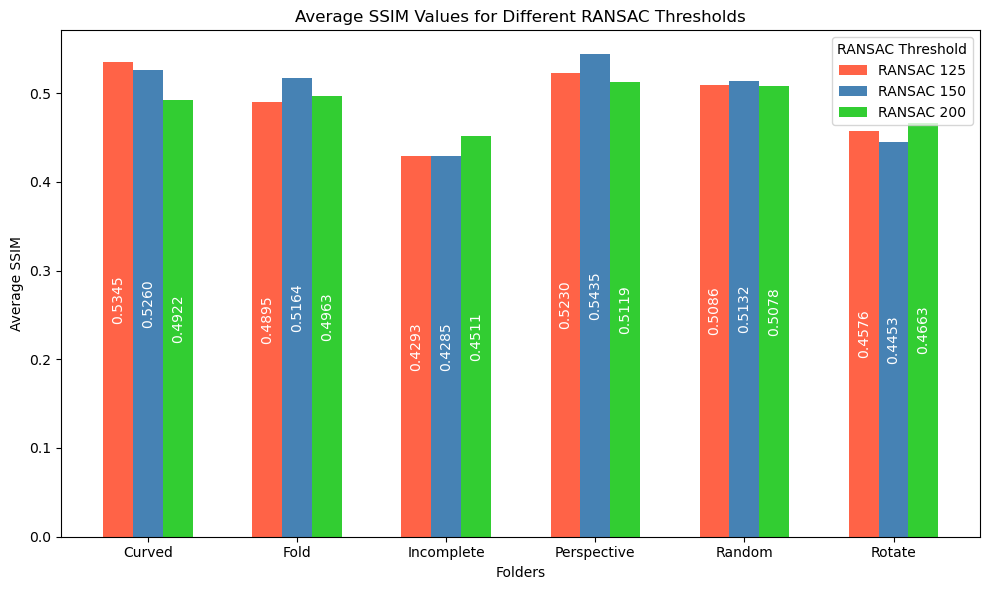

In [119]:
folders = ["Curved", "Fold", "Incomplete", "Perspective", "Random", "Rotate"]
ransac_thresholds = ["125", "150", "200"]
ssim_values = [
    [0.5345, 0.5260, 0.4922],  # Curved
    [0.4895, 0.5164, 0.4963],  # Fold
    [0.4293, 0.4285, 0.4511],  # Incomplete
    [0.5230, 0.5435, 0.5119],  # Perspective
    [0.5086, 0.5132, 0.5078],  # Random
    [0.4576, 0.4453, 0.4663],  # Rotate
]


colors = ["#FF6347", "#4682B4", "#32CD32", "#FFD700", "#9370DB", "#FF69B4"]


fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2  
x = np.arange(len(folders))

for i, threshold in enumerate(ransac_thresholds):
    bar_positions = x + i * bar_width  
    bars = ax.bar(bar_positions, [ssim[i] for ssim in ssim_values], 
                  bar_width, label=f"RANSAC {threshold}", color=colors[i % len(colors)])
    

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2, 
                f"{height:.4f}", ha='center', va='center', rotation=90, color="white", fontsize=10)


ax.set_xlabel("Folders")
ax.set_ylabel("Average SSIM")
ax.set_title("Average SSIM Values for Different RANSAC Thresholds")
ax.set_xticks(x + bar_width)
ax.set_xticklabels(folders)
ax.legend(title="RANSAC Threshold")

plt.tight_layout()
plt.show()
